## Raw % germination heatmap (means across replicates)

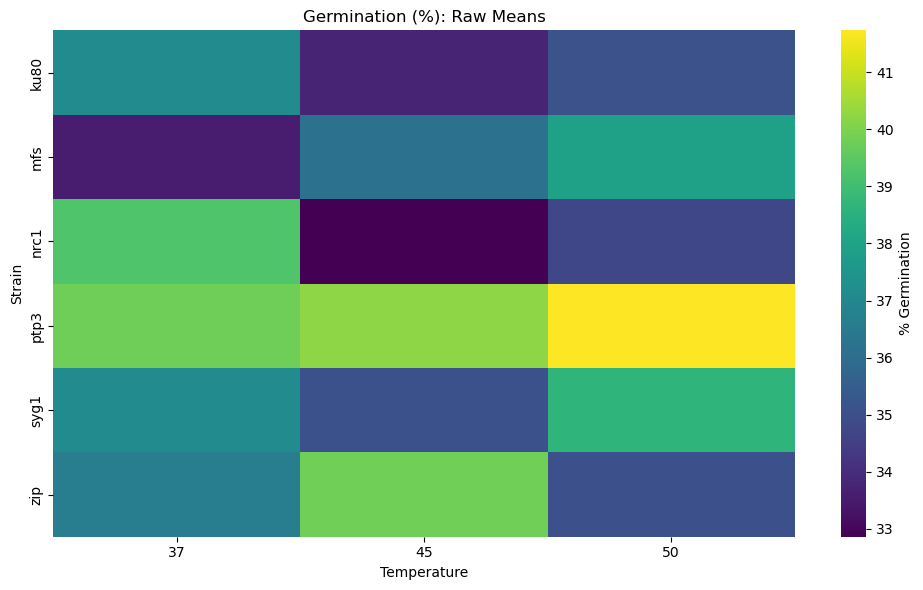

In [6]:
# ==== RAW % GERMINATION HEATMAP (robust column detection) ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv"

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    """Find first matching column in candidates (case-insensitive)."""
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}.\n"
                       f"Available columns: {list(df.columns)}")
    return None

def to_num_temp(x):
    """Extract numeric part of temperature like '45C' -> 45.0."""
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load ----
df = pd.read_csv(FILE)

# ---- Identify columns (case-insensitive, with synonyms) ----
strain_col = find_col(
    df, ["Strain", "strain", "Mutant", "mutant", "Genotype", "genotype"],
    purpose="strain"
)
temp_col = find_col(
    df, ["Temperature", "temperature", "Temp", "temp", "Temp_C", "temp_C"],
    purpose="temperature"
)

# Prefer a pre-computed percent column; otherwise compute from germinated/total
percent_col = find_col(
    df, ["percent_germinated", "Percent_Germinated", "%Germination", "Germination", "germination"],
    required=False
)
if percent_col is None:
    germ_col = find_col(df, ["germinated", "Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total", "Total", "count", "Count"], purpose="total count")
    # Compute % germination safely
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    value_col = "_PercentGerm"
else:
    # Coerce to numeric in case it's a string with % signs
    df["_PercentGerm"] = (
        pd.to_numeric(df[percent_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    )
    value_col = "_PercentGerm"

# ---- Clean and order temperatures numerically ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
# Build label order preserving the original text associated with sorted numeric temps
temp_labels = (
    df[[temp_col, "_TempNum"]]
    .drop_duplicates()
    .sort_values("_TempNum")[temp_col]
    .tolist()
)

# ---- Pivot (mean across replicates) ----
heat = df.pivot_table(
    index=strain_col,
    columns=temp_col,
    values=value_col,
    aggfunc="mean"
)[temp_labels]  # enforce numeric order

# ---- Plot ----
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heat, cmap="viridis", annot=False, fmt=".1f",
    cbar_kws={"label": "% Germination"}
)
ax.set_title("Germination (%): Raw Means")
ax.set_xlabel("Temperature")
ax.set_ylabel("Strain")
plt.tight_layout()
plt.show()


## Z-score heatmap (row-wise: per strain across temperatures)

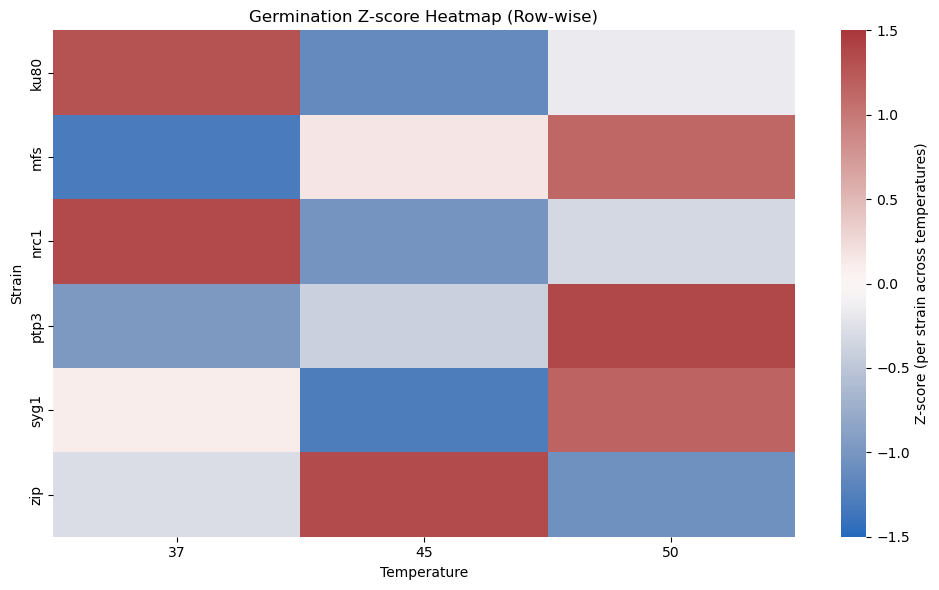

In [10]:
# ==== Z-SCORE HEATMAP (ROW-WISE: PER STRAIN across temperatures) =============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv"

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    """Find first matching column in candidates (case-insensitive)."""
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}.\n"
                       f"Available columns: {list(df.columns)}")
    return None

def to_num_temp(x):
    """Extract numeric part of temperature like '45C' -> 45.0."""
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load ----
df = pd.read_csv(FILE)

# ---- Identify columns (case-insensitive, with synonyms) ----
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")

# Prefer a pre-computed percent column; otherwise compute from germinated/total
percent_col = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"],
                       required=False)
if percent_col is None:
    germ_col  = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    value_col = "_PercentGerm"
else:
    df["_PercentGerm"] = pd.to_numeric(df[percent_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    value_col = "_PercentGerm"

# ---- Clean and order temperatures numerically ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]]
    .drop_duplicates()
    .sort_values("_TempNum")[temp_col]
    .tolist()
)

# ---- Pivot to mean % germination per (strain, temp) ----
mat = df.pivot_table(
    index=strain_col,
    columns=temp_col,
    values=value_col,
    aggfunc="mean"
)[temp_labels]

# ---- Row-wise Z-scores: (x - row_mean) / row_std ----
row_means = mat.mean(axis=1)
row_stds  = mat.std(axis=1, ddof=0)  # population std; use ddof=1 if you prefer sample std
z = (mat.sub(row_means, axis=0)).div(row_stds.replace(0, np.nan), axis=0)

# Optional: choose symmetric color limits based on data spread (nice for visuals)
abs_max = np.nanmax(np.abs(z.values))
if np.isfinite(abs_max):
    vmax = max(1.5, abs_max)   # at least ±1.5
else:
    vmax = 2
vmin = -vmax

# ---- Plot ----
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    z,
    cmap="vlag",          # diverging; zero centered
    center=0,
    vmin=vmin, vmax=vmax,
    annot=False,          # no numbers in cells
    cbar_kws={"label": "Z-score (per strain across temperatures)"}
)
ax.set_title("Germination Z-score Heatmap (Row-wise)")
ax.set_xlabel("Temperature")
ax.set_ylabel("Strain")
plt.tight_layout()
plt.show()


## Normalize each mutant by ku80 at the same temperature (mutant/ku80)

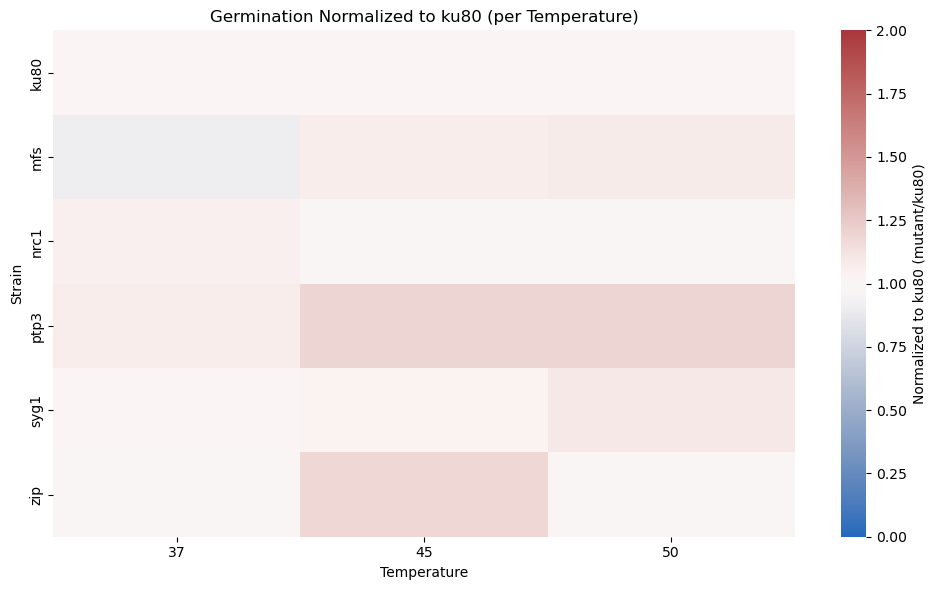

In [9]:
# ==== NORMALIZED BY KU80 (PER TEMPERATURE) ===================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv"
KU80_NAME = "ku80"  # reference strain label (case-insensitive)

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    """Find first matching column in candidates (case-insensitive)."""
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}.\n"
                       f"Available columns: {list(df.columns)}")
    return None

def to_num_temp(x):
    """Extract numeric part of temperature like '45C' -> 45.0."""
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load ----
df = pd.read_csv(FILE)

# ---- Identify columns (case-insensitive) ----
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")

# Prefer a pre-computed percent column; otherwise compute from germinated/total
percent_col = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"],
                       required=False)
if percent_col is None:
    germ_col = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    value_col = "_PercentGerm"
else:
    df["_PercentGerm"] = (
        pd.to_numeric(df[percent_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    )
    value_col = "_PercentGerm"

# ---- Clean and order temperatures numerically ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]]
    .drop_duplicates()
    .sort_values("_TempNum")[temp_col]
    .tolist()
)

# ---- Compute mean per (strain, temp) ----
means = (
    df.groupby([strain_col, temp_col], as_index=False)[value_col]
      .mean()
      .rename(columns={value_col: "MeanVal"})
)

# ---- Extract ku80 per temp and merge ----
is_ku80 = means[strain_col].str.strip().str.lower() == KU80_NAME.lower()
ref = means[is_ku80]
if ref.empty:
    raise ValueError(f"Reference strain '{KU80_NAME}' not found in column '{strain_col}'.")

ref = ref[[temp_col, "MeanVal"]].rename(columns={"MeanVal": "RefVal"})
norm = means.merge(ref, on=temp_col, how="left")

# Normalize each mutant by ku80 at that temperature
norm["NormVal"] = norm["MeanVal"] / norm["RefVal"].replace(0, np.nan)

# ---- Pivot ----
heat = norm.pivot_table(
    index=strain_col,
    columns=temp_col,
    values="NormVal",
    aggfunc="mean"
)[temp_labels]

# ---- Plot ----
label = f"Normalized to {KU80_NAME} (mutant/{KU80_NAME})"

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heat,
    cmap="vlag",         # diverging colormap is clearer for fold-changes
    center=1,            # center the color scale on 1 (reference level)
    annot=False,         # no numbers in cells
    cbar_kws={"label": label},
    vmin=0,
    vmax=max(2, np.nanmax(heat.values))  # adjust if needed
)
ax.set_title(f"Germination Normalized to {KU80_NAME} (per Temperature)")
ax.set_xlabel("Temperature")
ax.set_ylabel("Strain")
plt.tight_layout()
plt.show()


#### Clustermap on row-wise Z-scores (cluster rows, keep temp order)

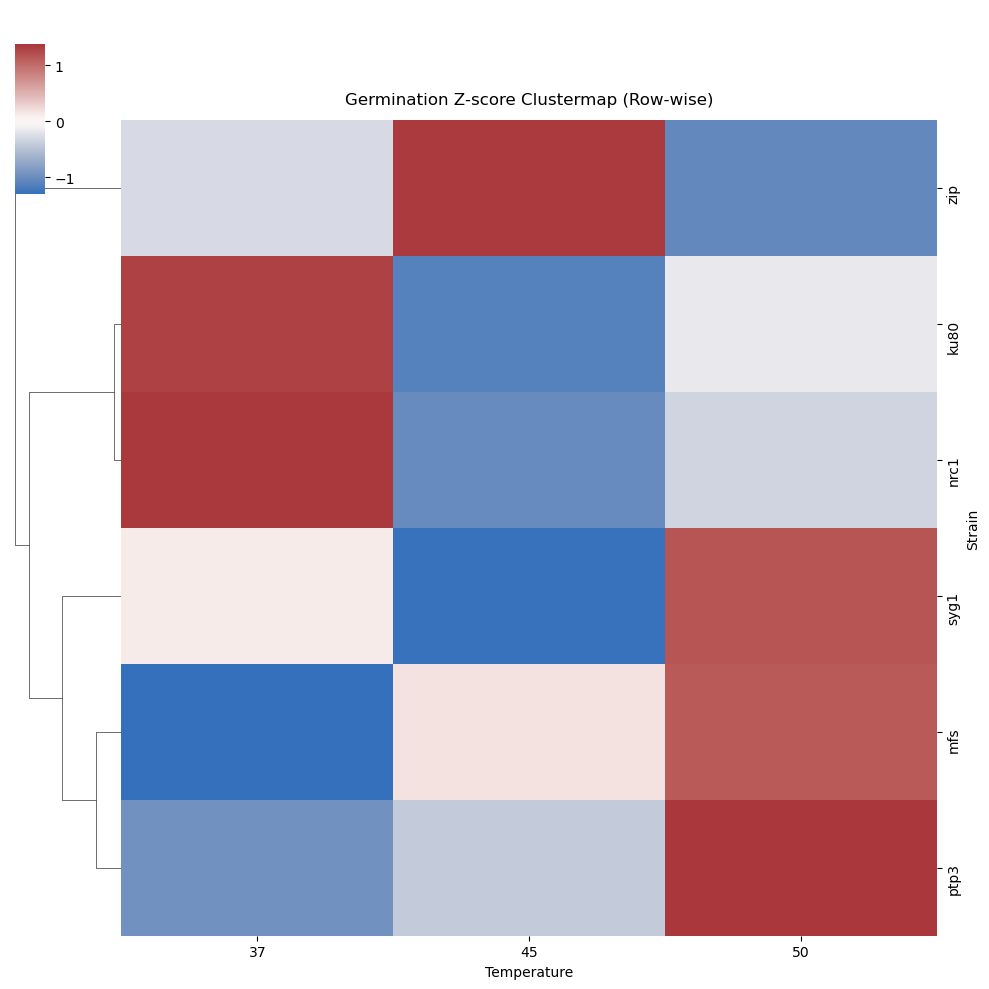

In [11]:
# ==== CLUSTERMAP: ROW-WISE Z-SCORES (cluster rows, keep temp order) ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv"
ROW_METRIC = "euclidean"   # e.g., "euclidean", "correlation", "cosine"
ROW_METHOD = "average"     # e.g., "average", "complete", "single", "ward"
COL_CLUSTER = False        # keep numeric temp order (False) or cluster columns (True)

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}. "
                       f"Available: {list(df.columns)}")
    return None

def to_num_temp(x):
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load & identify columns ----
df = pd.read_csv(FILE)
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")
pct_col    = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"], required=False)

# Build % germination if needed
if pct_col is None:
    germ_col  = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    val_col = "_PercentGerm"
else:
    df["_PercentGerm"] = pd.to_numeric(df[pct_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    val_col = "_PercentGerm"

# ---- Temperature order ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]].drop_duplicates().sort_values("_TempNum")[temp_col].tolist()
)

# ---- Pivot to means ----
mat = df.pivot_table(index=strain_col, columns=temp_col, values=val_col, aggfunc="mean")[temp_labels]

# ---- Row-wise Z-score ----
row_means = mat.mean(axis=1)
row_stds  = mat.std(axis=1, ddof=0)
z = (mat.sub(row_means, axis=0)).div(row_stds.replace(0, np.nan), axis=0)

# ---- Clustermap ----
# If keeping temp order, pass col_cluster=False so columns are not re-ordered.
g = sns.clustermap(
    z,
    cmap="vlag", center=0,
    metric=ROW_METRIC, method=ROW_METHOD,
    row_cluster=True, col_cluster=COL_CLUSTER,
    dendrogram_ratio=0.12, cbar_pos=(0.02, 0.8, 0.03, 0.15),  # tweak as you like
    linewidths=0, xticklabels=True, yticklabels=True
)
g.ax_heatmap.set_xlabel("Temperature")
g.ax_heatmap.set_ylabel("Strain")
g.ax_heatmap.set_title("Germination Z-score Clustermap (Row-wise)", pad=12)
plt.show()


#### Clustermap on ku80-normalized values (mutant/ku80 per temp)

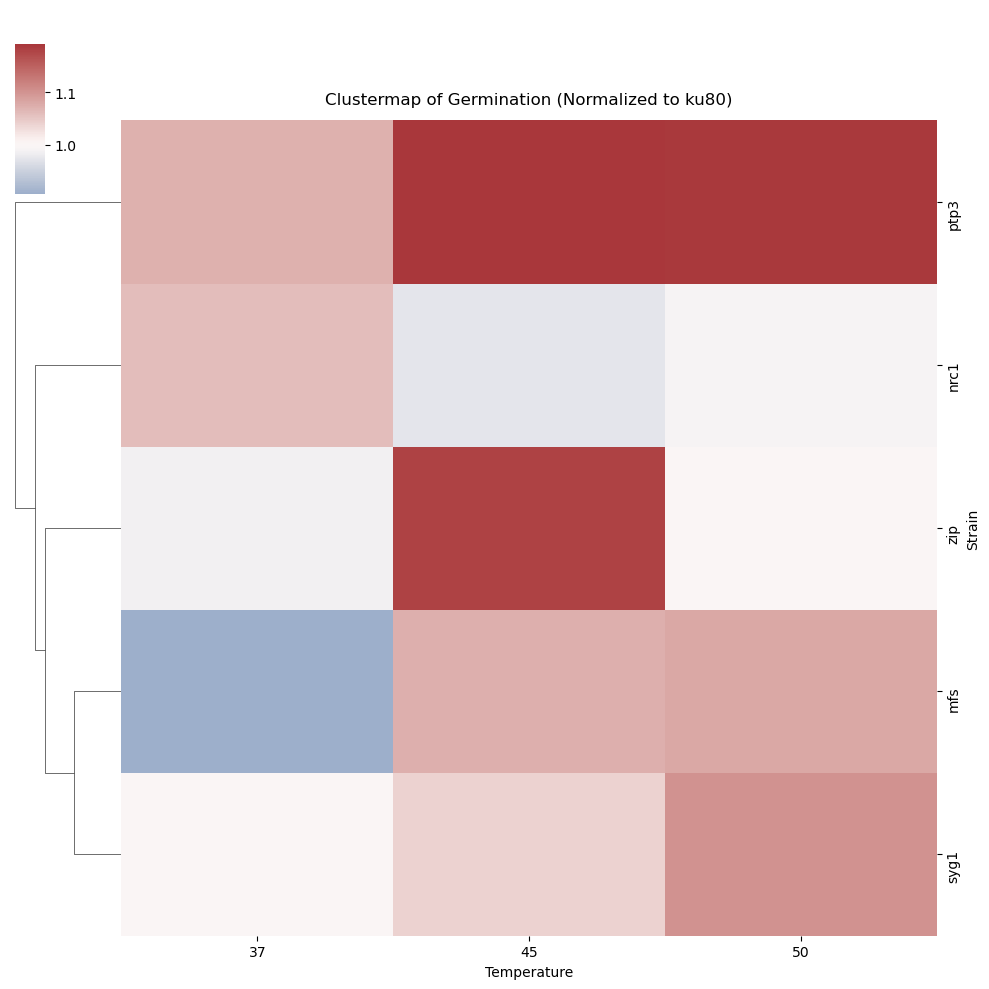

In [14]:
# ==== CLUSTERMAP: KU80-NORMALIZED (exclude ku80 itself) ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ---- Config ----
FILE = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv"
KU80_NAME = "ku80"         # case-insensitive
ROW_METRIC = "euclidean"
ROW_METHOD = "average"
COL_CLUSTER = False        # keep numeric temp order

# ---- Helpers ----
def find_col(df, candidates, required=True, purpose=""):
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    if required:
        raise KeyError(f"Could not find a column for {purpose or candidates}. "
                       f"Available: {list(df.columns)}")
    return None

def to_num_temp(x):
    m = re.search(r"-?\d+\.?\d*", str(x))
    return float(m.group()) if m else np.nan

# ---- Load & identify columns ----
df = pd.read_csv(FILE)
strain_col = find_col(df, ["Strain","strain","Mutant","mutant","Genotype","genotype"], purpose="strain")
temp_col   = find_col(df, ["Temperature","temperature","Temp","temp","Temp_C","temp_C"], purpose="temperature")
pct_col    = find_col(df, ["percent_germinated","Percent_Germinated","%Germination","Germination","germination"], required=False)

# Build % germination if needed
if pct_col is None:
    germ_col  = find_col(df, ["germinated","Germinated"], purpose="germinated count")
    total_col = find_col(df, ["total","Total","count","Count"], purpose="total count")
    df["_PercentGerm"] = (df[germ_col].astype(float) / df[total_col].replace(0, np.nan).astype(float)) * 100
    val_col = "_PercentGerm"
else:
    df["_PercentGerm"] = pd.to_numeric(df[pct_col].astype(str).str.replace("%","", regex=False), errors="coerce")
    val_col = "_PercentGerm"

# ---- Temperature order ----
df["_TempNum"] = df[temp_col].apply(to_num_temp)
temp_labels = (
    df[[temp_col, "_TempNum"]].drop_duplicates().sort_values("_TempNum")[temp_col].tolist()
)

# ---- Mean per (strain, temp) ----
means = (
    df.groupby([strain_col, temp_col], as_index=False)[val_col]
      .mean().rename(columns={val_col: "MeanVal"})
)

# ---- Normalize to ku80 at each temperature ----
is_ku80 = means[strain_col].str.strip().str.lower() == KU80_NAME.lower()
ref = means[is_ku80]
if ref.empty:
    raise ValueError(f"Reference strain '{KU80_NAME}' not found in '{strain_col}'.")
ref = ref[[temp_col, "MeanVal"]].rename(columns={"MeanVal": "RefVal"})
norm = means.merge(ref, on=temp_col, how="left")
norm["NormVal"] = norm["MeanVal"] / norm["RefVal"].replace(0, np.nan)

# ---- Pivot to matrix (exclude ku80 itself) ----
heat = norm.pivot_table(
    index=strain_col,
    columns=temp_col,
    values="NormVal",
    aggfunc="mean"
)[temp_labels]

# Drop the ku80 row (case-insensitive)
mask = heat.index.str.strip().str.lower() != KU80_NAME.lower()
heat = heat[mask]

# ---- Clustermap ----
g = sns.clustermap(
    heat, cmap="vlag", center=1,
    metric=ROW_METRIC, method=ROW_METHOD,
    row_cluster=True, col_cluster=COL_CLUSTER,
    dendrogram_ratio=0.12, cbar_pos=(0.02, 0.8, 0.03, 0.15),
    linewidths=0, xticklabels=True, yticklabels=True
)
g.ax_heatmap.set_xlabel("Temperature")
g.ax_heatmap.set_ylabel("Strain")
g.ax_heatmap.set_title(f"Clustermap of Germination (Normalized to {KU80_NAME})", pad=12)
plt.show()

